In [1]:
using Random
Random.seed!(13)

using CSV
using Plots
using DataFrames
using Statistics
using Missings
using Distributions
using StatsPlots
using LowRankModels, LinearAlgebra

In [2]:
include("proxgrad.jl")
df = CSV.read("airline.csv")

41396×20 DataFrame. Omitted printing of 18 columns
│ Row   │ airline_name  │ link                           │
│       │ String        │ String                         │
├───────┼───────────────┼────────────────────────────────┤
│ 1     │ adria-airways │ /airline-reviews/adria-airways │
│ 2     │ adria-airways │ /airline-reviews/adria-airways │
│ 3     │ adria-airways │ /airline-reviews/adria-airways │
│ 4     │ adria-airways │ /airline-reviews/adria-airways │
│ 5     │ adria-airways │ /airline-reviews/adria-airways │
│ 6     │ adria-airways │ /airline-reviews/adria-airways │
│ 7     │ adria-airways │ /airline-reviews/adria-airways │
│ 8     │ adria-airways │ /airline-reviews/adria-airways │
│ 9     │ adria-airways │ /airline-reviews/adria-airways │
│ 10    │ adria-airways │ /airline-reviews/adria-airways │
⋮
│ 41386 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41387 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41388 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41389 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41390 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41391 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41392 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41393 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41394 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41395 │ wizz-air      │ /airline-reviews/wizz-air      │
│ 41396 │ wizz-air      │ /airline-reviews/wizz-air      │

In [3]:
# Organize and display features along with variable type
feature_names = names(df)
for i in 1:20
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	airline_name			String
2	link			String
3	title			String
4	author			String
5	author_country			Union{Missing, String}
6	date			Dates.Date
7	content			String
8	aircraft			Union{Missing, String}
9	type_traveller			Union{Missing, String}
10	cabin_flown			Union{Missing, String}
11	route			Union{Missing, String}
12	overall_rating			Union{Missing, Float64}
13	seat_comfort_rating			Union{Missing, Float64}
14	cabin_staff_rating			Union{Missing, Float64}
15	food_beverages_rating			Union{Missing, Float64}
16	inflight_entertainment_rating			Union{Missing, Float64}
17	ground_service_rating			Union{Missing, Float64}
18	wifi_connectivity_rating			Union{Missing, Float64}
19	value_money_rating			Union{Missing, Float64}
20	recommended			Int64


Bag of words & manyhot function for text features

In [4]:
# Bag of words function to add bag of word features to data 

bag_of_words = ["good",
                "first",
                "entertainment",
                "friendly",
                "new",
                "comfortable",
                "great",
                "delayed",
                "excellent",
                "nice",
                "late",
                "better",
                "offered",
                "free",
                "delay",
                "helpful",
                "early",
                "pleasant",
                "best",
                "available",
                "efficient",
                "recommend",
                "uncomfortable",
                "cancelled",
                "comfort",
                "problems",
                "delays",
                "united",
                "cheap",
                "awful"
                ]

"Computes a manyhot vector for every entry in column given a bag of words"
function manyhot(column, words=bag_of_words)
    result = zeros(size(column,1), size(words,1))
    for i = 1:size(column,1)
        for j in 1:size(words,1)
            if occursin(words[j],column[i])
                result[i,j] = Int(1)
            end
        end
    end
    convert(Array{Int64,2},result)
end

manyhot

Filter data set to remove rows with missing features.
Split training and testing sets.

In [16]:
# Reduce number of datapoints for computation time

# Filter data to only consider entries with overall rating
df_OR = df[.!(ismissing.(df[!, :overall_rating])), :];

df_OR_filtered = df_OR[.!(ismissing.(df_OR[!, :seat_comfort_rating])), :]; 
data_OR_filtered = df_OR_filtered[.!(ismissing.(df_OR_filtered[!, :cabin_staff_rating])), :];
data_OR_filtered = data_OR_filtered[.!(ismissing.(df_OR_filtered[!, :content])), :];

# Now adding food_beverages_rating, inflight_entertainment_rating, and value money rating
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :food_beverages_rating])), :];
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :inflight_entertainment_rating])), :];
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :value_money_rating])), :];

train_proportion = 0.8
n = size(data_OR_filtered, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))
println("Size of train: ", string(round(train_proportion*n)))
println("Size of test: ", string(round(n-train_proportion*n)))

# Create manyhot bag of words binary array
df_content = data_OR_filtered[:, :content]
manyhot_data = manyhot(df_content)
for i = 1:size(bag_of_words,1)
   data_OR_filtered[!,Symbol(bag_of_words[i])] = manyhot_data[:,i]
end

target = data_OR_filtered[:, :recommended]

# Filter data for entries with only seat_comfort, cabin_staff
# df_OR_filtered = df_OR[.!(ismissing.(df[!, :seat_comfort_rating])), :]; 
# df_OR_filtered = df_OR[.!(ismissing.(df[!, :cabin_staff_rating])), :]; 
# data_OR_filtered = df_OR_filtered[:, filter(col -> (col != :overall_rating), feature_names)]

# the following variable records the features of examples in the training set
train_x = data_OR_filtered[1:ntrain,:]

# the following variable records the features of examples in the test set
test_x = data_OR_filtered[ntrain+1:end,:]

# the following variable records the labels of examples in the training set
train_y = target[1:ntrain]
train_y = collect(skipmissing(train_y))
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1:end]
test_y = collect(skipmissing(test_y));

Size of dataset: 28341
Size of train: 22673.0
Size of test: 5668.0


In [17]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    "Fill this in."
    num = size(y,1)
    error = sum(abs.((y.-pred).^2))/num
    return error
end

"""This function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted Rating", "True Rating", zeromin=true)
end

plot_pred_true

In [18]:
"This function converts strings to floating point values.
Strings that cannot be represented as a number (like NA) are converted to zeros"
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

labels_all = [
  :overall_rating,
  :seat_comfort_rating,
  :cabin_staff_rating,
  :food_beverages_rating,
  :inflight_entertainment_rating,
  :ground_service_rating,
  :wifi_connectivity_rating,
  :value_money_rating,
  :recommended
]

labels_real = [
    :seat_comfort_rating,
    :cabin_staff_rating,
    :food_beverages_rating,
    :inflight_entertainment_rating,
    :value_money_rating
]


symbol_words = Symbol[]

for word in bag_of_words
    push!(symbol_words,Symbol(word))
end

labels_all_words = vcat(labels_all,symbol_words);
labels_real_words = vcat(labels_real,symbol_words);

35-element Array{Symbol,1}:
 :seat_comfort_rating          
 :cabin_staff_rating           
 :food_beverages_rating        
 :inflight_entertainment_rating
 :value_money_rating           
 :good                         
 :first                        
 :entertainment                
 :friendly                     
 :new                          
 :comfortable                  
 :great                        
 :delayed                      
 ⋮                             
 :best                         
 :available                    
 :efficient                    
 :recommend                    
 :uncomfortable                
 :cancelled                    
 :comfort                      
 :problems                     
 :delays                       
 :united                       
 :cheap                        
 :awful                        

Filter data sets to only include features of interest. Current models includes the following labels:

   * Seat comfort rating
   * Cabin staff rating
   * Food beverage rating
   * Inflight entertainment rating
   * Value money rating
   * Bag of words text (30 words chosen)

In [19]:
# # Only converting for seat comfort and cabin staff
# train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating])]);
# test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating])]);
# size(train_vals_real,1)
# any(ismissing,train_vals_real)

# Only converting for seat comfort, cabin staff, food/beverage, and inflight entertainment
# train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating,:food_beverages_rating,:inflight_entertainment_rating,:value_money_rating])]);
# test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating,:food_beverages_rating,:inflight_entertainment_rating,:value_money_rating])]);
# size(train_vals_real,1)
# any(ismissing,train_vals_real)

# Only converting for seat comfort, cabin staff, food/beverage, and inflight entertainment AND BAG OF WORDS
train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real_words), labels_all_words)])
test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real_words), labels_all_words)])
size(train_vals_real,1)
any(ismissing,train_vals_real)

train_vals_real = convert(Array{Float64,2},train_vals_real)
test_vals_real = convert(Array{Float64,2},test_vals_real)

# # Add offset
train_vals_real = [train_vals_real ones(size(train_vals_real,1))];
test_vals_real = [test_vals_real ones(size(test_vals_real,1))];

[train_vals_real train_y]

22673×37 Array{Float64,2}:
 4.0  4.0  4.0  0.0  4.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 4.0  5.0  4.0  1.0  5.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  1.0
 5.0  5.0  4.0  0.0  5.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  1.0
 4.0  4.0  3.0  1.0  4.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  1.0
 4.0  2.0  1.0  2.0  2.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 4.0  4.0  3.0  3.0  4.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 4.0  4.0  1.0  0.0  3.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  1.0
 5.0  5.0  4.0  3.0  4.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  1.0
 4.0  3.0  4.0  1.0  4.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  1.0
 5.0  5.0  4.0  4.0  4.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  1.0
 4.0  4.0  4.0  4.0  4.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 4.0  5.0  3.0  3.0  5.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  1.0
 4.0  4.0  4.0  0.0  4.0  1.0  0.0  0

# Logistic Loss 

In [20]:
test_ybool = Int.(sign.(test_y))
train_ybool = Int.(sign.(train_y))

test_ybool[test_ybool.==0] .= -1
train_ybool[train_ybool.==0] .= -1

# Logistical Loss
loss_log = 1/n*LogisticLoss()

reg = ZeroReg()
# w_log = proxgrad(loss_log, reg, train_vals_real, train_ybool, maxiters=10000)
w_log = proxgrad(loss_log, reg, train_vals_real, train_ybool, maxiters=2000)

36-element Array{Float64,1}:
  0.2723142932645333  
  0.5338793401773051  
  0.1222044461271493  
 -0.020270171180299997
  0.9262498691415096  
  0.48684446290062733 
 -0.3028148480674913  
 -0.30317221899676533 
  0.38406671339056436 
  0.12383959812721926 
  0.22542814298646516 
  0.2902639128835334  
 -0.2909409998516157  
  ⋮                   
 -0.3422458317761914  
  0.42405588863753146 
  0.04068897388216613 
 -1.0615006325686596  
 -0.5862829467980641  
  0.044510191569111214
 -0.1307391452951586  
 -0.06257447441245167 
 -0.006325866534337531
 -0.21583214805859077 
 -0.5287529979701497  
 -5.56345747262084    

In [21]:
# Log loss misclassification on training set
n2 = length(train_ybool)
misclass_train = (n2 - sum(sign.(train_vals_real*w_log) .== train_ybool)) / n2

# Log loss misclassification on testing set
n = length(test_ybool)
misclass_test = (n - sum(sign.(test_vals_real*w_log) .== test_ybool)) / n

println("Training Misclassification Rate:\t", misclass_train)
println("Testing Misclassification Rate:\t", misclass_test)

Training Misclassification Rate:	0.08472632646760464
Testing Misclassification Rate:	0.08027522935779817


In [22]:
z = train_vals_real*w_log
scatter(z, train_y, label = "data y")
plot!(sort(z), sort(1 ./(1 .+exp.(-z))), label = "prediction")
# ylim(-.1, 1.1)
# legend(loc=2)
# xlabel("w^Tx")
# ylabel("y")
xlabel!("w^Tx")
ylabel!("y")

# Hinge Loss

In [23]:
loss_hinge = 1/n*HingeLoss()
reg = ZeroReg()
w_hinge = proxgrad(loss_hinge, reg, train_vals_real, train_ybool, maxiters=5000) 

36-element Array{Float64,1}:
  0.18254758071630253  
  0.3595066326305603   
  0.06545587619089663  
 -0.009536129366619704 
  0.5671023178369847   
  0.2960252458980252   
 -0.1496614767113653   
 -0.12988419085215364  
  0.19731938073394945  
  0.11059139577452443  
  0.13125978630028184  
  0.11100627977240797  
 -0.13785106629321742  
  ⋮                    
 -0.17692803899082515  
  0.26083040203775537  
 -0.0002239822247706696
 -0.6356077981651552   
 -0.3991942153316689   
  0.05401072909315427  
 -0.02798950798341578  
 -0.05971090441954926  
 -0.005548556589626759 
 -0.07463018811749854  
 -0.314746714008461    
 -3.6625793930839623   

In [24]:
# Hinge loss misclassification on training set
n2 = length(train_ybool)
misclass_train = (n2 - sum(sign.(train_vals_real*w_hinge) .== train_ybool)) / n2

# Hinge loss misclassification on testing set
n = length(test_ybool)
misclass_test = (n - sum(sign.(test_vals_real*w_hinge) .== test_ybool)) / n

println("Training Misclassification Rate:\t", misclass_train)
println("Testing Misclassification Rate:\t", misclass_test)

Training Misclassification Rate:	0.08133021655713844
Testing Misclassification Rate:	0.07392378263937897


0.00.010.020.030.040.050.060.070.080.090.10.110.120.130.140.150.160.170.180.190.2
Min Train Misclassification:	0.0834031667622282
Min Test Misclassification: 	0.07886379675370501
Optimal λ: 	0.0


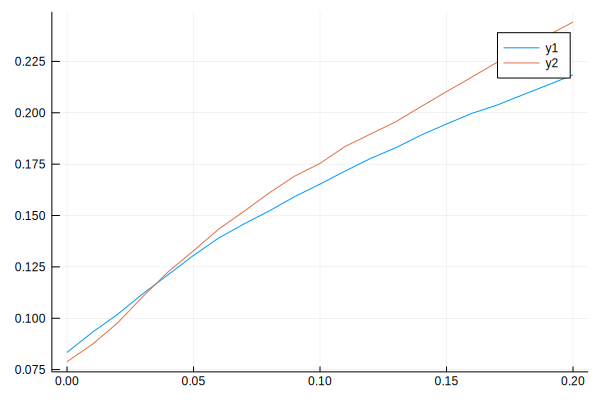

In [25]:
# test_ybool = Int.(sign.(test_y))
# train_ybool = Int.(sign.(train_y))

# test_ybool[test_ybool.==0] .= -1
# train_ybool[train_ybool.==0] .= -1

train_error_array = Float64[]
test_error_array = Float64[]

# Logistical Loss
loss_log = 1/n*LogisticLoss()

λs = 0:.01:0.2

for λ in λs
    print(λ)
    reg = QuadReg(λ)
    w_log = proxgrad(loss_log, reg, train_vals_real, train_ybool, maxiters=2000) 
    # Log loss misclassification on testing and training set
    n2 = length(train_ybool)
    misclass_train = (n2 - sum(sign.(train_vals_real*w_log) .== train_ybool)) / n2
    n = length(test_ybool)
    misclass_test = (n - sum(sign.(test_vals_real*w_log) .== test_ybool)) / n
    push!(train_error_array,misclass_train)
    push!(test_error_array,misclass_test)
end

println("")
println("Min Train Misclassification:\t", minimum(train_error_array))
println("Min Test Misclassification: \t", minimum(test_error_array))
println("Optimal λ: \t", λs[argmin(test_error_array)])
plot(λs,train_error_array)
plot!(λs,test_error_array)

In [ ]:
# test_ybool = Int.(sign.(test_y))
# train_ybool = Int.(sign.(train_y))

# test_ybool[test_ybool.==0] .= -1
# train_ybool[train_ybool.==0] .= -1

train_error_array = Float64[]
test_error_array = Float64[]

# Logistical Loss
loss_log = 1/n*HingeLoss()

λs = 0:.01:0.2

for λ in λs
    print(λ)
    reg = QuadReg(λ)
    w_log = proxgrad(loss_log, reg, train_vals_real, train_ybool, maxiters=3000) 
    # Log loss misclassification on testing and training set
    n2 = length(train_ybool)
    misclass_train = (n2 - sum(sign.(train_vals_real*w_log) .== train_ybool)) / n2
    n = length(test_ybool)
    misclass_test = (n - sum(sign.(test_vals_real*w_log) .== test_ybool)) / n
    push!(train_error_array,misclass_train)
    push!(test_error_array,misclass_test)
end

println("")
println("Min Train Misclassification:\t", minimum(train_error_array))
println("Min Test Misclassification: \t", minimum(test_error_array))
println("Optimal λ: \t", λs[argmin(test_error_array)])
plot(λs,train_error_array)
plot!(λs,test_error_array)

0.00.010.020.030.040.050.060.070.080.090.10.110.120.130.140.